Total de muestras en Grabacion_ballena.wav: 1968154


<IPython.core.display.Javascript object>


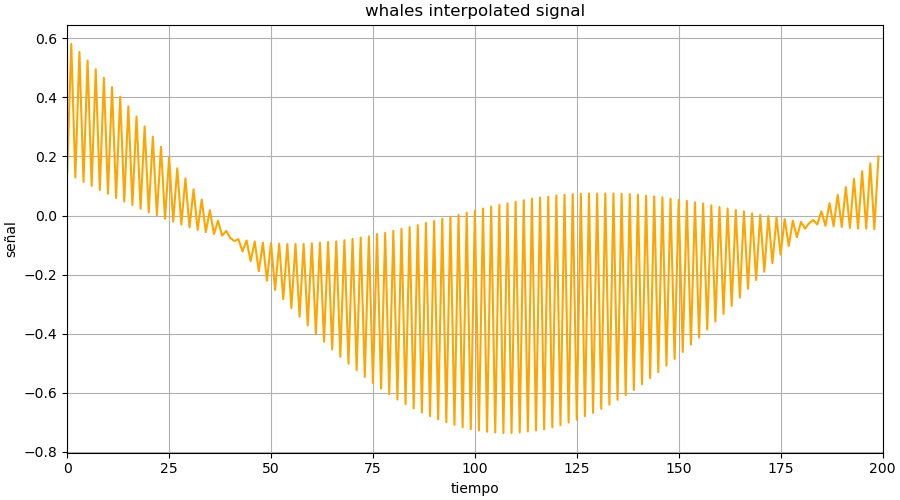

Total de muestras en Grabacion_grillos.wav: 2027520


<IPython.core.display.Javascript object>


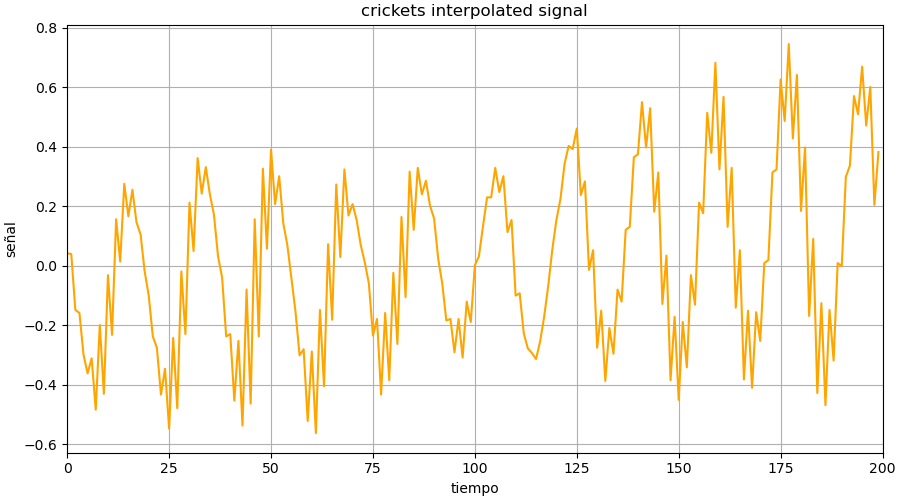

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import pandas as pd 


%matplotlib notebook


def save_signal_to_csv_file(signal, file_name):
    df = pd.DataFrame({'data': signal}) 
    df.to_csv('{}.csv'.format(file_name), index=False)


def plot_sound(signal, title):
    length = 200
    fig, axes = plt.subplots(constrained_layout=True, figsize=(9, 5))
    axes.plot(signal[0:length], '-', color='orange')
    axes.set_xlim(0, length)
    axes.set_title("{} signal".format(title))
    axes.set_xlabel('tiempo')
    axes.set_ylabel('señal')
    axes.grid(True)
    fig.show()
    
    
def extract_raw_from_wav_file(file, start, end):
    spf = wave.open(file, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    print('Total de muestras en {}: {}'.format(file, len(signal)))
    return signal[start:end]
    

def get_interpolated_signal(file, title, start, end):
    signal = extract_raw_from_wav_file(file, start, end)
    #plot_sound(wave, title)
    signal = np.interp(signal, (signal.min(), signal.max()), (-1, +1))
    plot_sound(signal, '{} interpolated'.format(title))
    save_signal_to_csv_file(signal, '{}_interpolated_wave'.format(title))
    return signal


whales_wave   = get_interpolated_signal("Grabacion_ballena.wav", "whales", 300000, 400000)
crickets_wave = get_interpolated_signal("Grabacion_grillos.wav", "crickets", 200000, 300000)



<IPython.core.display.Javascript object>


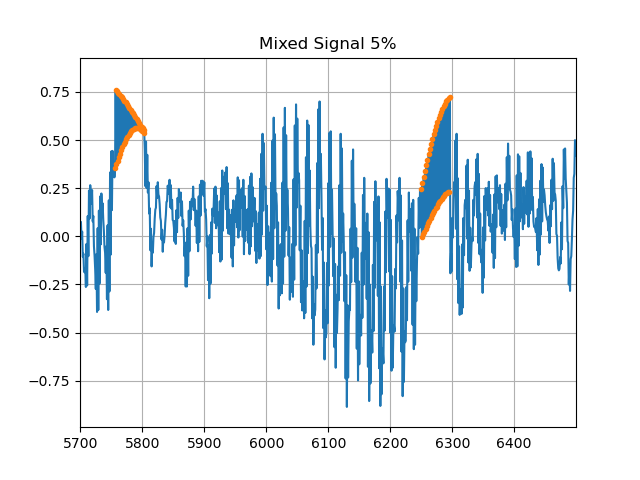

In [4]:
import pandas as pd 
from random import randrange, seed


def plot_mixed_signal(mixed_signal, anomaly_indexes, percentage):
    fig, axes = plt.subplots()
    axes.plot(mixed_signal)
    axes.plot(np.take(range(0, len(mixed_signal)), anomaly_indexes), np.take(mixed_signal, anomaly_indexes), '.')
    axes.set_title('Mixed Signal {}%'.format(percentage))
    axes.grid(True)
    fig.show()


def create_dataset(signal, labels, file_name):
    data = {'data': signal, 'label':labels} 
    df = pd.DataFrame(data) 
    df.to_csv(file_name, index=False)


def existOverlapping(new_start, new_end, intervals, minimum_distance):
    for start, end in intervals:
        if new_start >= start and new_start <= end:
            return True
        if new_end <= end and new_end >= start:
            return True
        if abs(new_start - end) < minimum_distance:
            return True
        if abs(start - new_end) < minimum_distance:
            return True
    return False


def get_intervals_from(signal, percentage):
    amount_of_points = int(np.floor(len(signal) * (percentage / 100)))
    intervals = list()
    min_length = 20
    max_length = 60
    seed( 350 * percentage ) # this is for repeatable results
    while (amount_of_points > 0):
        start  = randrange(0, len(signal))
        length = randrange(min_length, max_length)
        end    = (start + length - 1)
        if not existOverlapping(start, end, intervals, randrange(min_length, max_length)):
            amount_of_points -= length
            intervals.append((start, end if end < len(signal) else len(signal) - 1))
    return intervals


def intercalate_signals(first_signal, second_signal, percentage):
    labels = [0] * len(first_signal)
    for (start, end) in get_intervals_from(second_signal, percentage):
        print('({}, {})'.format(start, end))
        for i in range(start, end):
            labels[i] = 1
            first_signal[i] = second_signal[i]
    return first_signal, labels


def create_mixed_signal(percentages, signal_1, signal_2, file_name):
    for percentage in percentages:
        mixed_signal, labels = intercalate_signals(signal_1, signal_2, percentage)
        anomaly_indexes = np.where(np.asarray(labels) == 1)[0]
        create_dataset(mixed_signal, labels, file_name.format(percentage))
        plot_mixed_signal(mixed_signal, anomaly_indexes, percentage)


#create_mixed_signal([1, 2, 3, 5], crickets_wave, whales_wave, 'señal_grillos_y_ballena_v2_{}porciento.csv')
#create_mixed_signal([1, 2, 3, 5], whales_wave, crickets_wave, 'señal_ballena_y_grillos_v2_{}porciento.csv')
create_mixed_signal([7, 10], crickets_wave, whales_wave, 'señal_grillos_y_ballena_v2_{}porciento.csv')